## Il classificatore Baesyano come approccio linguistico alla individuazione automatica delle Fake News pt.0

L'elaborato nasce dalla volontà di scoprire, utilizzando algoritmi di machine learning e data mining, quali siano gli attributi caratteristici delle fake news, e se è possibile utilizzare un metodo automatico per comprendere se un testo è falso o vero. 

L'obbiettivo di questo progetto è quello di allenare un classificatore Baesyano su un dataset di notizie, composto da due fold: uno di fake news, e l'altro di notizie vere, ponendosi come vincolo l'attuazione di tutte le strategie per rendere il risultato il più accurato e robusto possibile.

Il dataset utilizzato è interamente in lingua inglese ed è stato creato utilizzando [snopes](www.snopes.com) come fonte; il sito giornalistico è stato scelto in quanto affidabile e soprattuto perchè contiene il link agli articoli di fake news originali, facendo si che la base dati utilizzata per questo progetto sia effettivamente quella che gli utenti si trovano davanti navigando in rete. 

La classificazione avverà su due base dati differenti:
1) Dataset non pre-processato, ovvero gli articoli verranno analizzati 'as is', senza manipolazione; 
2) Dataset pre-processato, ovvero al testo degli articoli verranno applicati tutti gli accorgimenti per disambiguare il significato delle parole all'interno del testo (Tokenizzazione - POS Tagging - Lemmatizzazione).

Questa prima analisi viene effettuata su una classificazione senza pre-processing, nella quale verranno analizzati tutti gli articoli 'as is',ovverno analizzati esattamente come sono stati scaricati dai relativi siti nei quali sono stati pubblicati. 

In [1]:
import nltk
from nltk import *
import random 
from nltk.corpus.reader import CategorizedPlaintextCorpusReader

L'implementazione del classificatore avviene utilizzando nltk, un pacchetto creato appositamente per l'analisi e le operazioni su corpora testuali.
L'oggetto CategorizedPlainTextCorpusReader lo utilizzeremo come 'contenitore' per il nostro dataset, nel quale verranno salvati gli articoli prima di essere processati. 

In [2]:
file = "snopes/dataset"
collCategorized= CategorizedPlaintextCorpusReader(file, r'.*\.txt', cat_pattern=r'(\w+)/*',encoding="utf8")
documents=[(list(collCategorized.words(fileid)), category) for category in collCategorized.categories() 
                for fileid in collCategorized.fileids(category)]
random.shuffle(documents)
print("Numero articoli:{}".format(len(documents)))

Numero articoli:1127


Il caricamento del dataset avviene utilizzando l'oggetto CategorizedPlaintextCorpusReader, che crea un database nel quale salva tutti gli articoli veri e tutti gli articoli falsi provenienti dalle rispettive cartelle.

Il risultato sarà dataset composto da una lista di tuple con questa struttura:
######  [(articolo,categoria), (articolo1,categoria1) ... (articolon,categorian)]
con articolo s'intende un articolo fisico all'interno del dataset 'Snopes'

con categoria s'intende la tipologia d'appartenenza dell'articolo, intesa come 'fake' o 'legit'.

Dopo il caricamento Documents, ovvero il dataset, viene mescolato in modo da prevenire lo stack degli articoli, i quali sono stati caricati in maniera seriale,nel senso che prima sono stati salvati quelli fake e poi quelli legit.

In [3]:
listaFreq=nltk.FreqDist(w.lower() for w in collCategorized.words())
word_features=[x for (x,_) in listaFreq.most_common()]                                                                                                                                                                                                               

print("Numero totale parole: {} \nGrandezza dizionario: {}".format(len(collCategorized.words()),len(listaFreq)))

Numero totale parole: 2240042 
Grandezza dizionario: 31907


Viene creata la lista di frequenze delle parole all'interno del corpus: essa verrà utilizzata nella creazione delle features.
Il numero totale di parole utilizzato nei 1127 articoli è poco più di due milioni, mentre il dizionario totale (ovvero le parole utilizzate all'interno degli articoli prese una sola volta) è grande 31907. 
La nostra base dati nella quale andremo ad effettuare la classificazione può quindi può definirsi medio-piccola, in confronto alla totalità delle parole all'interno del dizionario inglese (circa 800.000 segni), ma altamente specifica.

In [4]:
def document_features(document):
    document_words=set(document)
    features={}
    for word in word_features:
        features["contains({})".format(word)]=(word in document_words)
    return features

featuresets_doc=[(document_features(d), c) for (d, c) in documents]
size = int(len(featuresets_doc) * 0.9)
train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)

print("Accuratezza classificazione: {}".format(nltk.classify.accuracy(classifier_doc, test_set_doc)*100))
range_data = nltk.classify.accuracy(classifier_doc, test_set_doc)*100
classifier_doc.show_most_informative_features(10)

Accuratezza classificazione: 79.88165680473372
Most Informative Features
             contains(0) = True             fake : legit  =     20.7 : 1.0
             contains(+) = True             fake : legit  =     10.1 : 1.0
            contains(24) = True             fake : legit  =     10.1 : 1.0
             contains(–) = True             fake : legit  =      8.5 : 1.0
          contains(upon) = True             fake : legit  =      8.2 : 1.0
        contains(please) = True             fake : legit  =      8.2 : 1.0
             contains(&) = True             fake : legit  =      7.8 : 1.0
         contains(below) = True             fake : legit  =      6.7 : 1.0
           contains(isn) = True             fake : legit  =      6.3 : 1.0
           contains(won) = True             fake : legit  =      6.1 : 1.0


Le features vengono create prendendo in considerazione le parole più frequenti nel testo e la loro appartenenza a una categoria predefinita: se una parola compare spesso in articoli di categoria 'fake', è molto probabile che essa sia un'evidenza dell'articolo falso.

Per ogni articolo nel dataset e per ogni parola all'interno di esso si ricerca la sua presenza nelle parole più frequenti del dataset, ponendo 'TRUE' se è accertata la presenza e 'FALSE' se non risulta. 
Le feature così create poi vengono divise in due parti: una parte dedita all'allenamento, ampia il 90% delle feature totali, mentre l'altra ha lo scopo di verificare la capacità di generalizzazione della classificazione, ed è grande come il 10% delle feature totali. 
Il classificatore quindi allena la prima parte, mentre riserva la seconda per la fase di test: il confronto tra queste due misure ricaverà l'accuratezza. 

La stampa a video mostra il risultato della classificazione, interpretabile come:
La parola x, contenuta o non contenuta nell'articolo y (contains(x) = True significa che la parola è contenuta nell'articolo, mentre  contains(x) = False significa che la parola non è contenuta nell'articolo), si riscontra in articoli fake n volte e in articoli legit n volte. 
La proporzione fake:legit = nfake:nlegit porterà al peso della parola per dichiarare la categoria dell'articolo
Se la frequenza di apparizione di una parola si riscontra maggiormente in un articolo fake, allora essa sarà un'evidenza della possibile falsità dell'articolo.

La parola 'please', (contains=(please) = True), è contenuta in articoli fake 8.2 volte che in quelli legit; quindi la parola 'please', quando la si ritrova in un testo, porta il suo peso (8.2) a favore della falsità dell'articolo. 

In [5]:
print("Cross validation on 10 fold:")
from sklearn import cross_validation
cv = cross_validation.KFold(len(train_set_doc), n_folds=10, shuffle=False, random_state=None)
i = 1
for traincv, evalcv in cv:
    classifier = nltk.NaiveBayesClassifier.train(train_set_doc[traincv[0]:traincv[len(traincv)-1]])
    print('Accuracy '+str(i)+'° fold: %.3f' % nltk.classify.util.accuracy(classifier, train_set_doc[evalcv[0]:evalcv[len(evalcv)-1]]))  
    i = i+1

Cross validation on 10 fold:
Accuracy 1° fold: 0.636


C:\WinPython-64bit-3.5.3.0Qt5\python-3.5.3.amd64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy 2° fold: 0.727
Accuracy 3° fold: 1.000
Accuracy 4° fold: 0.900
Accuracy 5° fold: 0.800
Accuracy 6° fold: 1.000
Accuracy 7° fold: 0.900
Accuracy 8° fold: 0.900
Accuracy 9° fold: 0.900
Accuracy 10° fold: 0.800


La crossvalidation è un metodo di verifica della bontà di una classificazione: l'intero insieme di feature viene diviso in folds, ovvero parti più piccole del dataset in cui verrà praticata la classificazione. Questo permette di mettere in luce errori dovuti  alla scarsa generalizzazione del modello: se i risultati attraverso i vari fold non sono troppo differenti, allora la classificazione si può definire robusta.

La classificazione sull'intero dataset porta un'accuratezza circa dell'80%. 

Ma è questa l'accuratezza massima che può avere il modello? 

## Test sull'accuratezza della classificazione

La base dati di una classificazione ottimale non comprende tutti gli elementi all'interno del dataset: più feature si sono, più si rischia di diluire le vere evidenze della categoria con feature dal valore informativo basso o nullo. 
Questo è facilmente intuibile pensando a come parole dal basso contenuto informativo, come articoli o congiunzioni, siano molto più frequenti rispetto a elementi altamente informativi, come verbi o nomi.
Di rigetto però, non si possono togliere a priori gli elementi informativi con maggior frequenza, perchè porterebbe a uno snaturamento troppo forzato del contesto informativo e quindi di conseguenza il grado di generalizzazione della classificazione ne sarebbe compromesso.
Per questo motivo è necessario trovare una porzione di frequenza la quale classificazione dia un'accuratezza massima, in modo da avere una buona sorgente di informazioni che siano il più predittive possibile della categoria a cui si riferiscono. 
La ricerca di questo range non può essere che effettuata mediante valutazioni empiriche: di seguito vi è la divisione delle parole più frequenti in porzioni dall'ampiezza variabile, in modo da verificare quando si ha un'accuratezza maggiore.

La frequenza relativa delle parole è stata divisa in slices:

    partendo da 0 con il primo slice da 500, porzioni da 100 (0-500, 500-600, 600-700 ...)
    
    partendo da 0 con il primo slice da 700, porzioni da 100 (0-700, 700-800, 800-900 ...)
    
    partendo da 0, slice da 500 incrementali (0-5000, 0-1000, 0,1500 ...)
    
    partendo da 0, porzioni da 500 (0-500, 500-1000, 1000-1500 ...)
    
    partendo da 0, porzioni da 700 (0-700, 7000-1400, 700-1400 ...)
    
    partendo da 0, porzioni da 1000 (0-1000, 1000-2000, 2000-3000 ...)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def test_Accuracy(principio, final,parte,veces,caja,incr):
    x = 1
    while(x <= count):
        featuresets_doc=[(document_features(d,principio,final), c) for (d, c) in documents]
        size = int(len(featuresets_doc) * 0.9)
        train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
        classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
        print("\r{}° Range: {} to {} most frequent words, Accuracy: {}".format(x,principio,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
        caja.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
        if (incr==True):
            principio,final = principio+parte,final+parte
        else:
            principio,final = principio,final+parte
        x = x+1
    return caja

def dibujar(caja,count,parte):
    print("\n Grafico 1 in corso...")
    plt.plot(caja,'r')
    plt.xlabel("Range: {} word".format(parte))
    plt.ylabel("Accuracy")
    plt.show()
    print("\n Grafico 2 in corso...")    
    plt.plot(caja, 'r--o')
    plt.axis([0,count,10,100])
    plt.xlabel("Range: {} word".format(parte))
    plt.ylabel("Accuracy")
    plt.show()
    
def document_features(document,principio,final):
    document_words=set(document)
    features={}
    word_features=[x for (x,_) in listaFreq.most_common()[principio:final]]
    for word in word_features:
        features["contains({})".format(word)]=(word in document_words)
    return features

La segmentazione delle frequenze avviene nella funzione test_Accuracy, nella quale ripetiamo per 15 volte una classificazione su uno slice sempre diverso di frequenze, in modo da osservare l'andamento dell'accuratezza in base al variare delle parole in ingresso.
In questo modo si tolgono dalla classificazione parole sempre più frequenti e si aggiungono parole sempre meno frequenti, trovando alla fine una finestra di compromesso. 

Dibujar è la funzione che ci permette di visualizzare il risultato di ogni classificazione attraverso un grafico.

15° Range: 1400 to 1900 most frequent words, Accuracy: 71.10453648915187
 Grafico 1 in corso...


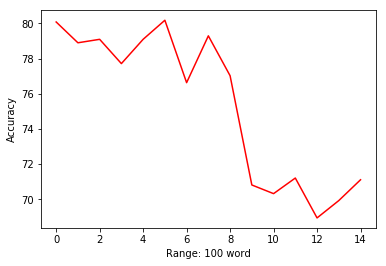


 Grafico 2 in corso...


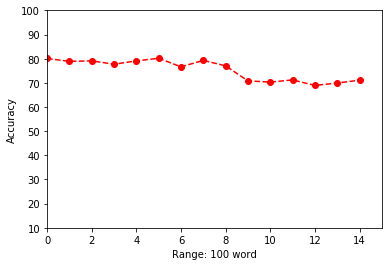

,Accuracy 0-500 con slice 100
0,80.078895
1,78.895464
2,79.092702
3,77.712032
4,79.092702
5,80.177515
6,76.627219
7,79.289941
8,77.021696
9,70.808679


In [7]:
a = 0
b = 500
r = 100
count = 15
res_s0_e500_r100 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e500_r100,True),count,r)
pd1 = pd.DataFrame({"Accuracy 0-500 con slice 100":res_s0_e500_r100})
pd1

15° Range: 1400 to 2100 most frequent words, Accuracy: 72.18934911242604
 Grafico 1 in corso...


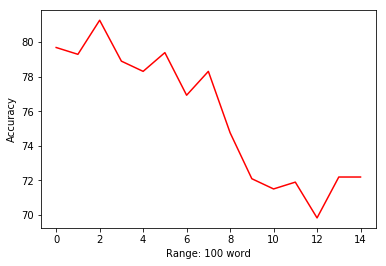


 Grafico 2 in corso...


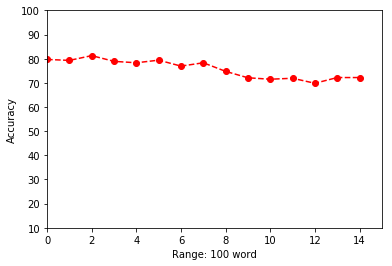

,Accuracy 0-700 con slice 100
0,79.684418
1,79.289941
2,81.262327
3,78.895464
4,78.303748
5,79.388560
6,76.923077
7,78.303748
8,74.753452
9,72.090730


In [8]:
a = 0
b = 700
r = 100
count = 15
res_s0_e700_r100 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e700_r100,True),count,r)
pd2 = pd.DataFrame({"Accuracy 0-700 con slice 100":res_s0_e700_r100})
pd2

15° Range: 0 to 7500 most frequent words, Accuracy: 76.62721893491124
 Grafico 1 in corso...


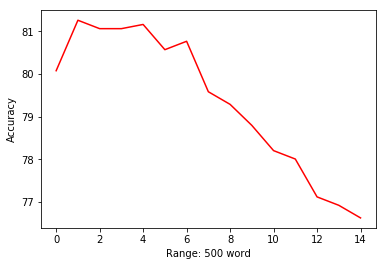


 Grafico 2 in corso...


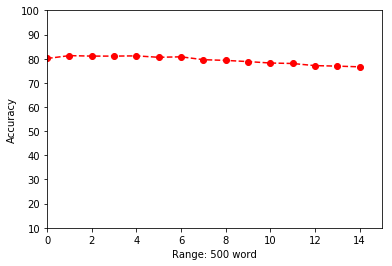

,Accuracy 0-500 con slice 500 incrementale
0,80.078895
1,81.262327
2,81.065089
3,81.065089
4,81.163708
5,80.571992
6,80.769231
7,79.585799
8,79.289941
9,78.796844


In [9]:
a = 0
b = 500
r = 500
count = 15
res_s0_e500_r500_incremental = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e500_r500_incremental,False),count,r)
pd3 = pd.DataFrame({"Accuracy 0-500 con slice 500 incrementale":res_s0_e500_r500_incremental})
pd3

15° Range: 7000 to 7500 most frequent words, Accuracy: 66.66666666666666
 Grafico 1 in corso...


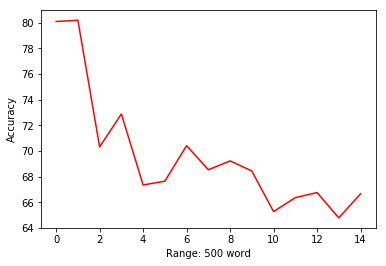


 Grafico 2 in corso...


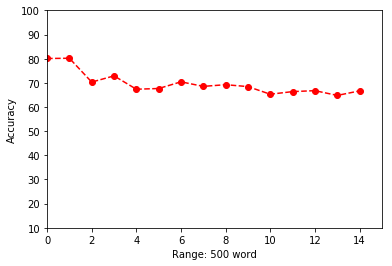

,Accuracy 0-500 con slice di 500
0,80.078895
1,80.177515
2,70.315582
3,72.879684
4,67.357002
5,67.652860
6,70.414201
7,68.540434
8,69.230769
9,68.441815


In [10]:
a = 0
b = 500
r = 500
count = 15
res_s0_e500_r500 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e500_r500,True),count,r)
pd4 = pd.DataFrame({"Accuracy 0-500 con slice di 500":res_s0_e500_r500})
pd4

15° Range: 9800 to 10500 most frequent words, Accuracy: 65.28599605522683
 Grafico 1 in corso...


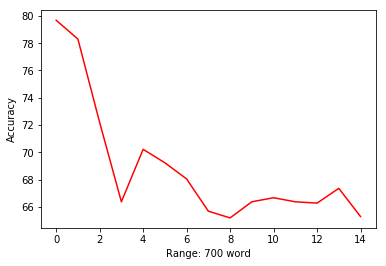


 Grafico 2 in corso...


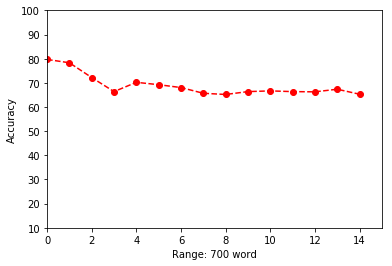

,Accuracy 0-700 con slice di 700
0,79.684418
1,78.303748
2,72.189349
3,66.370809
4,70.216963
5,69.230769
6,68.047337
7,65.680473
8,65.187377
9,66.370809


In [11]:
a = 0
b = 700
r = 700
count = 15
res_s0_e700_r700 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e700_r700,True),count,r)
pd5 = pd.DataFrame({"Accuracy 0-700 con slice di 700":res_s0_e700_r700})
pd5

15° Range: 14000 to 15000 most frequent words, Accuracy: 65.08875739644971
 Grafico 1 in corso...


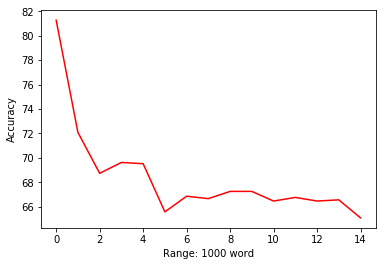


 Grafico 2 in corso...


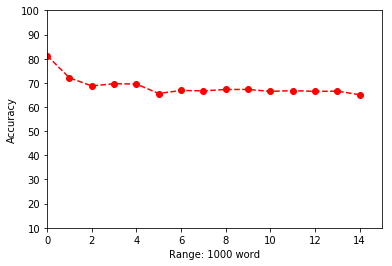

,Accuracy 0-1000 con slice di 1000
0,81.262327
1,72.090730
2,68.737673
3,69.625247
4,69.526627
5,65.581854
6,66.863905
7,66.666667
8,67.258383
9,67.258383


In [12]:
a = 0
b = 1000
r = 1000
count = 15
res_s0_e1000_r1000 = []
dibujar(test_Accuracy(a,b,r,count,res_s0_e1000_r1000,True),count,r)
pd6 = pd.DataFrame({"Accuracy 0-1000 con slice di 1000":res_s0_e1000_r1000})
pd6

In [13]:
pd1.join(pd2).join(pd3).join(pd4).join(pd5).join(pd6)

,Accuracy 0-500 con slice 100,Accuracy 0-700 con slice 100,Accuracy 0-500 con slice 500 incrementale,Accuracy 0-500 con slice di 500,Accuracy 0-700 con slice di 700,Accuracy 0-1000 con slice di 1000
0,80.078895,79.684418,80.078895,80.078895,79.684418,81.262327
1,78.895464,79.289941,81.262327,80.177515,78.303748,72.090730
2,79.092702,81.262327,81.065089,70.315582,72.189349,68.737673
3,77.712032,78.895464,81.065089,72.879684,66.370809,69.625247
4,79.092702,78.303748,81.163708,67.357002,70.216963,69.526627
5,80.177515,79.388560,80.571992,67.652860,69.230769,65.581854
6,76.627219,76.923077,80.769231,70.414201,68.047337,66.863905
7,79.289941,78.303748,79.585799,68.540434,65.680473,66.666667
8,77.021696,74.753452,79.289941,69.230769,65.187377,67.258383
9,70.808679,72.090730,78.796844,68.441815,66.370809,67.258383


La tabella riassuntiva dell'accuratezza del modello: si nota come essa varia in maniera limitata quando considera le feature a massima frequenza, mentre cala in maniera vistosa quando la classificazione si effettua su feature con frequenza più bassa. 

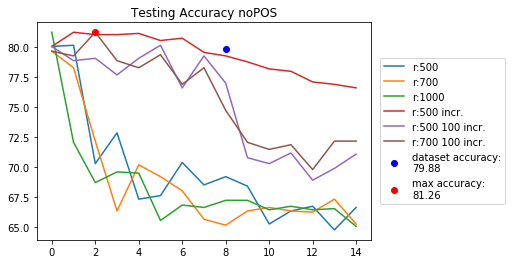

In [28]:
import matplotlib.pyplot as plt
import numpy as np
p = res_s0_e500_r500 + res_s0_e700_r700 + res_s0_e1000_r1000 + res_s0_e500_r500_incremental + res_s0_e500_r100 + res_s0_e700_r100

maximo = 0
for i in p:
    if (i > maximo):
        maximo = i
        
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Testing Accuracy noPOS')
ax.plot(res_s0_e500_r500, label='r:500')
ax.plot(res_s0_e700_r700, label='r:700')
ax.plot(res_s0_e1000_r1000, label='r:1000')
ax.plot(res_s0_e500_r500_incremental, label='r:500 incr.')
ax.plot(res_s0_e500_r100, label='r:500 100 incr.')
ax.plot(res_s0_e700_r100, label='r:700 100 incr.')
ax.plot(8,range_data,'bo', label='dataset accuracy:\n{}'.format(round(range_data,2)))
ax.plot(2,maximo,'ro', label='max accuracy:\n{}'.format(round(maximo,2)))
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc='right', bbox_to_anchor=(1.4,0.5),borderaxespad=0)
plt.show()

fig.savefig("Testing_Accuracy",bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=400)

Il risultato del testing ci porta a osservare come l'accuratezza sia dipendente dalle feature selezionate: è evidente come l'aumento del numero di feature prese in considerazione non porti sempre a una maggior robustezza del modello. 
Il risultato di questo 'slicing' ci porta ad osservare che l'accuratezza migliore è 81.27% riscontrata in tre sezioni:
200-900, 0-1000.
Si prende in considerazione lo slice minore in quanto significa che ha gli elementi più informativi.
L'accuratezza prendendo in considerazione l'intero dataset è di 79.88%.

L'obbiettivo è sempre quello di migliorare la classificazione, aggiustando la finestra ideale di feature nella quale effettuare la classificazione. A scaglioni di 50 feature, si verifica l'accuratezza del modello sulla base dati equivalente.

In [17]:
def document_featureshuffle(document,principio,final):
    document_words=set(document)
    features={}
    word_features=[x for (x,_) in listaFreq.most_common()[principio:final]]
    random.shuffle(word_features)
    random.shuffle(word_features)
    for word in word_features:
        features["contains({})".format(word)]=(word in document_words)
    return features

In [36]:
begin = 200
final = 900
final_more = []
final_less = []
begin_more = []
begin_less = []
count = 10
hace = True
jump = 50
if (begin==0):
    hace = False
i = 1

print("From {} to {}: from the end up to {} words".format(begin,final,jump))
while i <= count:
    featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in documents]
    size = int(len(featuresets_doc) * 0.9)
    train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
    classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
    print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
    final_more.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
    final = final + jump
    i = i+1
pd_end_up = pd.DataFrame({"Accuracy end up to 50":final_more})

begin = 200
final = 900
i = 1
print("\nFrom {} to {}: from the end down to {} words".format(final,begin,jump))
while i <= count:
    featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in documents]
    size = int(len(featuresets_doc) * 0.9)
    train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
    classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
    print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc,test_set_doc)*100),end='')
    final_less.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
    final = final - jump
    i = i+1 
pd_end_down = pd.DataFrame({"Accuracy end down to 50":final_less})

begin = 200
final = 900
i = 1    
print("\nFrom {} to {}: from the beginning up to {} words".format(begin,final,jump))
while i <= count:
    featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in documents]
    size = int(len(featuresets_doc) * 0.9)
    train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
    classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
    print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
    begin_more.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
    begin = begin + 50
    i = i+1
pd_begin_up = pd.DataFrame({"Accuracy begin up to 50":begin_more})

begin = 200
final = 900
i = 1
if (hace):
    print("\nFrom {} to {}: from the beginning down to {} words".format(final,begin - jump*10,jump))
    while i <= count:
            featuresets_doc=[(document_featureshuffle(d,begin,final), c) for (d, c) in documents]
            size = int(len(featuresets_doc) * 0.9)
            train_set_doc, test_set_doc = featuresets_doc[size:], featuresets_doc[:size]
            classifier_doc=nltk.NaiveBayesClassifier.train(train_set_doc)
            print("\r{}° slice: from {} to {}, accuracy: {}".format(i,begin,final,nltk.classify.accuracy(classifier_doc, test_set_doc)*100),end='')
            begin_less.append(nltk.classify.accuracy(classifier_doc, test_set_doc)*100)
            begin = begin - 50
            i = i+1
            if (begin < 0):
                break
    pd_begin_down = pd.DataFrame({"Accuracy begin down to 50":begin_less})
else:
     pd_begin_down = pd.DataFrame({"Accuracy begin down to 50":[]})

From 200 to 900: from the end up to 50 words
10° slice: from 200 to 1350, accuracy: 81.26232741617358
From 900 to 200: from the end down to 50 words
10° slice: from 200 to 450, accuracy: 80.57199211045365
From 200 to 900: from the beginning up to 50 words
10° slice: from 650 to 900, accuracy: 76.72583826429981
From 900 to -300: from the beginning down to 50 words
5° slice: from 0 to 900, accuracy: 80.6706114398422247

In [37]:
pd_end_up.join(pd_end_down).join(pd_begin_up).join(pd_begin_down)

,Accuracy end up to 50,Accuracy end down to 50,Accuracy begin up to 50,Accuracy begin down to 50
0,81.262327,81.262327,81.262327,81.262327
1,81.262327,81.558185,79.881657,81.262327
2,81.262327,79.487179,79.487179,80.769231
3,81.163708,80.276134,79.289941,81.558185
4,81.163708,79.092702,79.092702,80.670611
5,81.854043,79.881657,78.402367,NaN
6,81.558185,80.374753,79.388560,NaN
7,81.459566,80.966469,76.232742,NaN
8,81.558185,78.895464,76.528600,NaN
9,81.262327,80.571992,76.725838,NaN


I risultati sopra riportati ci mostrano l'aggiustamento dell'accuratezza. 
Nell'ultima colonna abbiamo dei risultati parziali, visto che la grandezza dello slice aveva raggiunto il limite consentito.

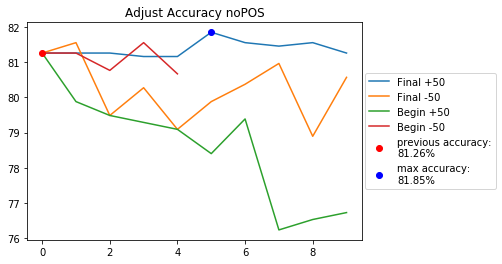

In [38]:
import matplotlib.pyplot as plt
import numpy as np
p_ =  final_more+final_less+begin_more+begin_less

maximo_ = 0
for i in p_:
    if (i > maximo_):
        maximo_ = i

fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.title('Adjust Accuracy noPOS')
ax.plot(final_more, label="Final +50")
ax.plot(final_less, label="Final -50")
ax.plot(begin_more, label="Begin +50")
ax.plot(begin_less, label="Begin -50")

ax.plot(0,maximo,'ro', label='previous accuracy:\n{}%'.format(round(maximo,2)))
ax.plot(5,maximo_,'bo', label='max accuracy:\n{}%'.format(round(maximo_,2)))

handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc='right', bbox_to_anchor=(1.4,0.5),borderaxespad=0)
plt.show()

fig.savefig("Adjust_Accuracy",bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=400)

L'accuratezza è migliorata nello slice 200:1150, passando dal 81.26% all'81.85%

La variazione viene mostrata in grafico:

- Se aumentiamo la finestra di feature in coda (quindi aggiungiamo elementi a bassa frequenza), l'accuratezza non varia molto, e ha una tendenza ad abbassarsi;

- Se sottraiamo la finestra di feature in coda (quindi togliamo elementi a bassa frequenza), l'accuratezza non varia molto, e ha una tendenza ad abbassarsi.

- Se sottraiamo la finestra di feature in testa (quindi togliamo elementi ad alta frequenza), l'accuratezza cala drasticamente: questo vuol dire che il classificatore è molto dipendente dalle prime feature rispetto alle ultime, ovvero prende molte più informazioni dalle parole con frequenza alta rispetto alle parole con frequenza bassa.

- Se aumentiamo la finestra di feature in testa (quindi aggiungiamo elementi ad alta frequenza), l'accuratezza ha una tendenza a salire e a stabilizzarsi.

Questo porta alla conclusione che le parole meno informative del testo (articoli, punteggiatura, congiunzioni...) sono gli elementi da cui la classificazione guadagna più evidenze.

### In conclusione: 

Analizzando l'andamento dell'accuratezza della classificazione, si nota come la finestra con l'accuratezza maggiore si abbia nello slice di frequenze [200:1150].

Le parole contenute nello slice a massima accuratezza sono: 

In [39]:
pdwords = pd.DataFrame(listaFreq.most_common()[200:1150], columns=['Word', 'Frequency'])
pdwords.pivot('Word','Frequency')
pdwords

,Word,Frequency
0,russian,1299
1,re,1283
2,.“,1280
3,clinton,1278
4,am,1276
5,times,1273
6,post,1270
7,12,1268
8,article,1262
9,find,1261
